In [1]:
from collections import  defaultdict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
sns.set(palette = 'gist_earth', style='white')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm_notebook as tqdm

from sklearn.manifold import TSNE

In [4]:
quotes = []
max_len = 0
min_len = 5
sent_len_dic = defaultdict(int)

# Try different encodings
encodings_to_try = ['utf-8', 'latin-1', 'ISO-8859-1', 'windows-1252']

for encoding in encodings_to_try:
    try:
        with open('prepared.txt', 'r', encoding=encoding) as f:
            while True:
                quote = f.readline()
                if not quote:
                    break
                words = quote.split(' ')
                sent_len = len(words)
                if sent_len < min_len:
                    continue
                max_len = sent_len if sent_len > max_len else max_len
                sent_len_dic[sent_len] += 1
                flag = False
                for i in range(0, 10):
                    if str(i) in quote:
                        flag = True
                        break
                if flag:
                    continue
                quote = quote.replace(',', ' ,').replace('.', ' .').replace('_', '').strip('\n') + ' ;'
                quotes.append(quote.lower())
        # If reading succeeds without error, break the loop
        break
    except UnicodeDecodeError:
        continue


In [5]:
print(f'Sentences with\nmin count words : {min_len}\nmax count words : {max_len}')

Sentences with
min count words : 5
max count words : 50


In [6]:
len(quotes)

2665

In [7]:
words_dict = dict()
def unique_words(data_list):
  for x in data_list:
    for word in x.split(' '):
      words_dict[word] = 1
  return words_dict.keys()


In [8]:
words = list(unique_words(quotes))
words.sort()

In [9]:
len(words)

4305

In [10]:
word_to_int = dict()
int_to_word = dict()
vocab_len = len(words)
for i in range(0, vocab_len):
  word_to_int[words[i]] = i
  int_to_word[i] = words[i]

In [11]:
co_occ_matrix = defaultdict(int)
window = 5 # not greater than 5
for sent in quotes:
  words = sent.split(' ')
  # first window
  for i in range(0, window):
    for j in range(i+1, window):
      weight = 1/(j-i)
      ind_1 = word_to_int[words[i]]
      ind_2 = word_to_int[words[j]]
      if ind_1 == ind_2:
        continue
      co_occ_matrix[(ind_1, ind_2)] += weight
      co_occ_matrix[(ind_2, ind_1)] += weight
  # rest windows
  for i in range(window, len(words)):
    for j in range(i-window, i):
      weight = 1/(i-j)
      ind_1 = word_to_int[words[i]]
      ind_2 = word_to_int[words[j]]
      if ind_1 == ind_2:
        continue
      co_occ_matrix[(ind_1, ind_2)] += weight
      co_occ_matrix[(ind_2, ind_1)] += weight

<ipython-input-12-b202298d5b62>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(topk)


<Axes: ylabel='Density'>

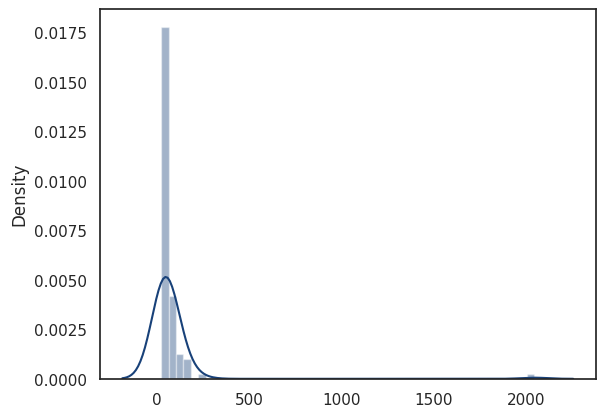

In [12]:
topk, ind = torch.topk(torch.tensor(list(co_occ_matrix.values())), 200)
sns.distplot(topk)

<Axes: >

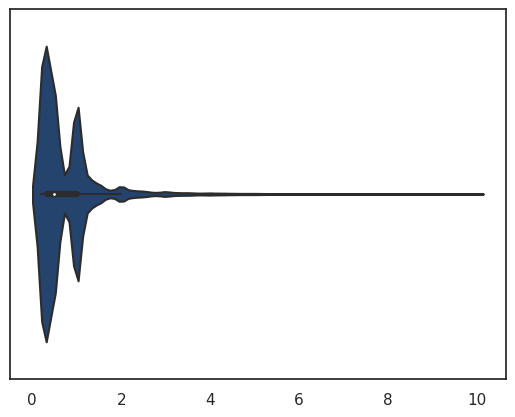

In [13]:
elem_den = []
for i in co_occ_matrix.values():
  if i > 0 and i < 10:
    elem_den.append(i)
sns.violinplot(x = elem_den)

In [14]:
tot_pairs = len(co_occ_matrix)
p1, p2,occs = list(), list(), list()
for i in co_occ_matrix.keys():
    p1.append(i[0])
    p2.append(i[1])
    occs.append(co_occ_matrix[i])
p1 = np.array(p1)
p2 = np.array(p2)
occs = np.array(occs)

In [15]:
occs.size

90102

In [16]:
def get_batch(batch_size):
  ind = np.random.permutation(occs.size).tolist()
  i = 0
  for i in range(0, tot_pairs, batch_size):
    batch_ids = ind[i:i+batch_size]
    yield p1[batch_ids], p2[batch_ids], occs[batch_ids]

In [17]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [18]:
class Glove(nn.Module) :
  def __init__(self, vocab_len, num_dim,):
    super(Glove, self).__init__()
    self.ui = nn.Embedding(vocab_len, num_dim).to(device)
    self.uj = nn.Embedding(vocab_len, num_dim).to(device)
    self.bi = nn.Embedding(vocab_len, 1).to(device)
    self.bj = nn.Embedding(vocab_len, 1).to(device)

    self.ui.weight.data.uniform_(-1,1)
    self.uj.weight.data.uniform_(-1,1)
    self.bi.weight.data.zero_()
    self.bj.weight.data.zero_()

  def forward(self, i_vecs, j_vecs):
    i_s = self.ui(i_vecs)
    j_s = self.uj(j_vecs)
    b_i = torch.squeeze(self.bi(i_vecs))
    b_j = torch.squeeze(self.bj(j_vecs))
    return torch.sum(i_s * j_s, dim = 1) + b_i + b_j

In [19]:
num_dim = 128
glove = Glove(vocab_len, num_dim).to(device)


In [20]:
def f_x(x, x_max, alpha):
  x = (x/x_max)**alpha
  return torch.min(x, torch.ones_like(x)).to(device)

def weight_mse(w_x, x, log_x):
  loss = w_x * F.mse_loss(x, log_x, reduction='none')
  return torch.mean(loss).to(device)

In [21]:
epochs = 30
batch_size = 64
batch_count = 0
x_max = 1
alpha = 0.75
loss_trace = []
n_bathces = int(math.floor(len(occs)/batch_size))
optimizer = optim.Adagrad(glove.parameters(), lr=0.15)
for epoch in tqdm(range(epochs)):
  batch_count = -1
  for ind_1, ind_2, occ in get_batch(batch_size):
    batch_count += 1
    occ = torch.FloatTensor(occ).to(device)
    optimizer.zero_grad()
    y_hat = glove.forward(torch.tensor(ind_1).to(device),
                          torch.tensor(ind_2).to(device))
    w_x = f_x(occ, x_max, alpha)
    loss = weight_mse(w_x, y_hat, torch.log(occ))
    loss.backward()
    optimizer.step()
    loss_trace.append(loss.item())
    if batch_count == n_bathces:
      break
  print(f"Epoch : {epoch + 1} ----> Loss : {loss_trace[-1]}")

<ipython-input-21-f704c1b45cf8>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(epochs)):


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch : 1 ----> Loss : 2.816469192504883
Epoch : 2 ----> Loss : 7.252768516540527
Epoch : 3 ----> Loss : 1.3813749551773071
Epoch : 4 ----> Loss : 0.6742268800735474
Epoch : 5 ----> Loss : 0.38223516941070557
Epoch : 6 ----> Loss : 0.3104605972766876
Epoch : 7 ----> Loss : 0.32269051671028137
Epoch : 8 ----> Loss : 0.20151713490486145
Epoch : 9 ----> Loss : 0.1607300490140915
Epoch : 10 ----> Loss : 0.20570026338100433
Epoch : 11 ----> Loss : 0.1584184616804123
Epoch : 12 ----> Loss : 0.20268945395946503
Epoch : 13 ----> Loss : 0.4730634093284607
Epoch : 14 ----> Loss : 0.191865473985672
Epoch : 15 ----> Loss : 0.08626402914524078
Epoch : 16 ----> Loss : 0.21400465071201324
Epoch : 17 ----> Loss : 0.13051675260066986
Epoch : 18 ----> Loss : 0.12858429551124573
Epoch : 19 ----> Loss : 0.14052289724349976
Epoch : 20 ----> Loss : 0.05736701563000679
Epoch : 21 ----> Loss : 0.17902013659477234
Epoch : 22 ----> Loss : 0.09883394837379456
Epoch : 23 ----> Loss : 0.0866616889834404
Epoch : 24

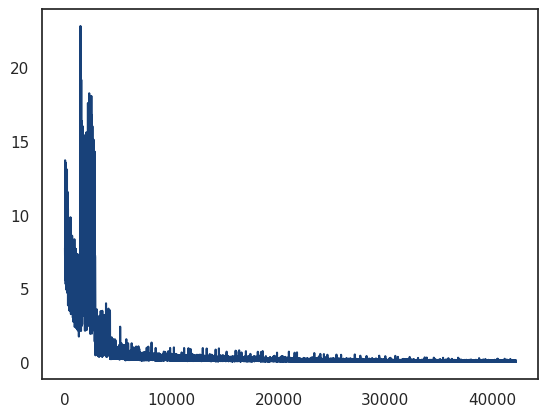

In [22]:
plt.plot(loss_trace)

In [23]:
torch.save(glove, 'glove.pth')

In [24]:
glove = torch.load('glove.pth',device)

In [25]:
glove.eval()

Glove(
  (ui): Embedding(4305, 128)
  (uj): Embedding(4305, 128)
  (bi): Embedding(4305, 1)
  (bj): Embedding(4305, 1)
)

In [26]:
emb_i = glove.ui.weight.cpu().data.numpy()
emb_j = glove.uj.weight.cpu().data.numpy()
emb = emb_i + emb_j

In [27]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300,metric='cosine')
n_points = 100
emb_tsne = tsne.fit_transform(emb[:n_points, :])

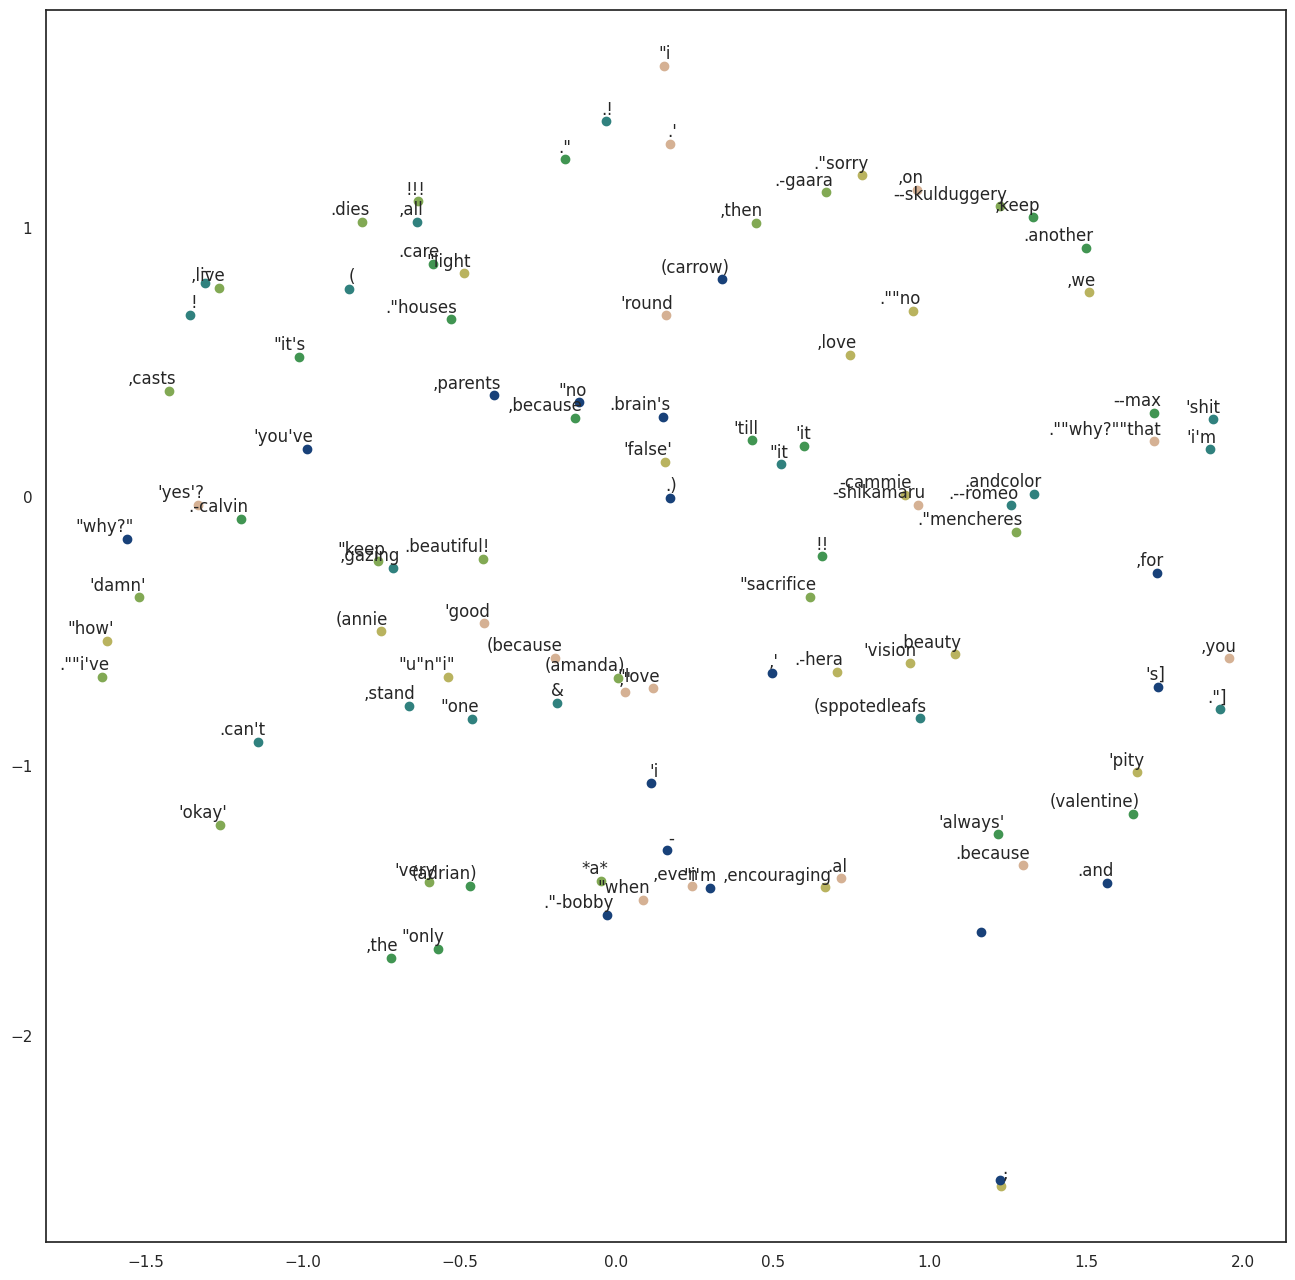

In [28]:
labels = list(word_to_int.keys())[:n_points]
x = emb_tsne[:,0]
y = emb_tsne[:,1]
plt.figure(figsize=(16, 16))
for i in range(n_points):
  plt.scatter(x[i],y[i])
  plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2),
               textcoords='offset points', ha='right', va='bottom')

In [29]:
max_sent_len = 50
window = 5
sequences, next_words = [], []
for quote in quotes:
  words = quote.split(' ')
  for i in range(0,len(words) - window + 1):
    sequences.append(words[i:i+window])
    if (i + window) < len(words):
      next_words.append(words[i+window])
    else:
      next_words.append(';')

In [30]:
print("{0:^40} {1}".format('Sequence', 'Next_Word'))
print('-'*50)
for i in range(20):
  print(f"{' '.join(sequences[i]) : <40} {next_words[i] : ^10}")

                Sequence                 Next_Word
--------------------------------------------------
we accept the love we                      think   
accept the love we think                     we    
the love we think we                      deserve  
love we think we deserve                     .     
we think we deserve .                        ;     
think we deserve . ;                         ;     
love all , trust a                          few    
all , trust a few                            ,     
, trust a few ,                              do    
trust a few , do                           wrong   
a few , do wrong                             to    
few , do wrong to                           none   
, do wrong to none                           .     
do wrong to none .                           ;     
wrong to none . ;                            ;     
to die will be an                         awfully  
die will be an awfully                      big    
will be an awf

In [31]:
tot_seq = len(next_words)
print(tot_seq)

15674


In [32]:
X = np.zeros((tot_seq, window, num_dim))
Y = np.zeros((tot_seq,vocab_len))
for i,seq in enumerate(sequences):
  for j,word in enumerate(seq):
    num_id = word_to_int[word]
    X[i][j] = np.squeeze(emb[num_id])
  num_id = word_to_int[next_words[i]]
  Y[i][num_id] = 1

In [33]:
X.shape, Y.shape

((15674, 5, 128), (15674, 4305))

In [34]:
def get_batches_x(tot_seq, batch_size):
  ind = np.random.permutation(tot_seq).tolist()
  i = 0
  for i in range(0, tot_seq, batch_size):
    batch_ids = ind[i:i+batch_size]
    yield X[batch_ids], Y[batch_ids]

In [35]:
class Quote_Generator(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_len):
    super(Quote_Generator, self).__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(embed_size, hidden_size, batch_first = True).to(device)
    self.dropout = nn.Dropout(0.4)
    self.dense = nn.Linear(hidden_size*5, vocab_len).to(device)

  def forward(self, x, prev_state):
    output, state = self.lstm(x)
    output = self.dropout(output)
    logits = self.dense(output.reshape(-1, hidden_size*5))
    return logits, state

  def zero_states(self, batch_size):
    return (torch.zeros(1, batch_size, self.hidden_size).to(device),
            torch.zeros(1, batch_size, self.hidden_size).to(device))

In [36]:
def entropy_loss(y, y_hat):
  y_hat = F.softmax(y_hat, dim = 1)
  ll = - (y * torch.log(y_hat))
  return torch.sum(ll, dim = 1).mean().to(device)

In [37]:
embed_size = 128
hidden_size = 64
qt_gen = Quote_Generator(embed_size, hidden_size, vocab_len).to(device)

In [38]:
epochs = 50
batch_size = 4096
losses = []
optimizer = torch.optim.Adam(qt_gen.parameters(), lr=0.001)
for epoch in tqdm(range(epochs)):
  batches = get_batches_x(tot_seq, batch_size)
  h_h, h_c = qt_gen.zero_states(batch_size)
  for x,y in batches:
    qt_gen.train()
    optimizer.zero_grad()
    x = torch.tensor(x).float().to(device)
    y = torch.tensor(y).long().to(device)
    logits, (h_h, h_c) = qt_gen(x, (h_h, h_c))
    loss = entropy_loss(y, logits)
    h_h.detach()
    h_c.detach()
    loss.backward()
    _ = nn.utils.clip_grad_norm_(qt_gen.parameters(), 5)
    optimizer.step()
    losses.append(loss.item())
  if (epoch) % 10 == 0:
    print(f"Epoch : {epoch} ----> Loss : {np.array(losses).mean()}")
  losses = []

<ipython-input-38-ff6d34fb7f62>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(epochs)):


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 0 ----> Loss : 8.348747253417969
Epoch : 10 ----> Loss : 4.726864218711853
Epoch : 20 ----> Loss : 4.218264818191528
Epoch : 30 ----> Loss : 3.908602297306061
Epoch : 40 ----> Loss : 3.646733582019806


In [39]:
torch.save(qt_gen, 'qt_gen.pth')

In [40]:
qt_gen = torch.load('qt_gen.pth', device)
qt_gen.eval()

Quote_Generator(
  (lstm): LSTM(128, 64, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (dense): Linear(in_features=320, out_features=4305, bias=True)
)

In [41]:
def predict(x, temp):
  probs = F.softmax(x / temp, dim = 0)
  probs = np.squeeze(probs.detach().cpu().numpy())
  ind = np.random.choice(6361, 1, p = probs)
  return ind[0]

In [125]:
import torch
import numpy as np
import torch.nn.functional as F

# Assuming the 'predict' function generates probabilities for words

def predict(x, temp):
    probs = F.softmax(x / temp, dim=0)
    probs = np.squeeze(probs.detach().cpu().numpy())
    ind = np.random.choice(len(probs), 1, p=probs)
    return ind[0]
# End of the predict function

generated_text = ['there', 'is', 'no', 'one', 'love']
curr_len = 0
embeds = []
is_end = word_to_int[';']  # Assuming ';' is the end token in your vocabulary

qt_gen.eval()

for i in generated_text:
    embeds.append(emb[word_to_int[i]])

while curr_len < 10:
    curr_len += 1
    input_tensor = torch.Tensor(embeds).view(1, 5, 128).float().to(device)
    h_h, h_c = qt_gen.zero_states(1)
    output, (h_h, h_c) = qt_gen(input_tensor, (h_h, h_c))
    word_ind = predict(output[-1], 1.6)

    # Updating the embeds list with the embedding of the newly predicted word
    embeds[0] = emb[word_ind]
    generated_text.append(int_to_word[word_ind])

    if word_ind == is_end:
        break


In [126]:
' '.join(generated_text)

'there is no one love remain everything saw sun ;'

#The dataset used by us , is very limited .The usage of large datasets is exhausting our systems resources. But iam sure the model has an capability of acheving state of the art results , if trained on large corpus:)

In [46]:
torch.cuda.empty_cache()